
##Chapter 3. The Restricted Two Body Problem

###Action by Diego.A Acosta, University of Antioquia

In this notebook we will present part of the theoretical background of the chapter devoted to the Two body problem and some mathematical and numerical results which are interested for the theory.

For details on the theory please refer directly to the book:

    Murray, C. D., & Dermott, S. F. (1999). Solar system dynamics. Cambridge university press.



##Libraries


In [138]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [139]:
## !pip install spiceypy -q (Collab)
## !pip install celluloid -q (Collab)
from spiceypy import rotate,mxv
from scipy.integrate import odeint
from celluloid import Camera
from IPython.core.display import HTML

## SECTION 3.2 Equation of Motion

the equations of motion in the synodic frame become

$\begin{aligned} \ddot{x}-2 n \dot{y}-n^2 x & =-\left[\mu_1 \frac{x+\mu_2}{r_1^3}+\mu_2 \frac{x-\mu_1}{r_2^3}\right] . \\ \bar{y}+2 \pi \dot{x}-n^2 y & =-\left[\frac{\mu_1}{r_1^3}+\frac{\mu_2}{r_2^3}\right] y . \\ z & =-\left[\frac{\mu_1}{r_1^3}+\frac{\mu_2}{r_2^3}\right] z .\end{aligned}$



*   $x,y,z$ = Position vector
*   $\dot{x}, \dot{y}, \dot{z}$ = Velocity vector
*   $n$ = Mean motion
*   $r_1, r_2$ = Position of test particle respect to $m_1$ and $m_2$
*   $\mu_1$ = 1 - $\mu$
*   $\mu2$ = $\mu$

In [140]:
def CRTBP(Y0,t,alpha,dt = 100):
    """
    Numerical solution to Circular Restriced Three Body Problem
    Input:
    Y: Positional vector [x,y,z,vx,vy,vz]
    t: Time of Integration 
    alpha: Parameter m2/(m1+m2)
    """
    def equation(Y,t):
        x,y,z,vx,vy,vz = Y
        mu1 = 1-alpha
        mu2 = alpha
        r1 = np.sqrt((x+mu2)**2 + y**2+z**2)
        r2 = np.sqrt((x-mu1)**2 + y**2+z**2)
        
        mu_r1 = mu1/(r1**3)
        mu_r2 = mu2/(r2**3)

        ax = 2*vy+x-(x+mu2)*mu_r1-(x-mu1)*mu_r2
        ay = -2*vx+y - (mu_r1+mu_r2)*y
        az = -(mu_r1+mu_r2)*z
        
        return [vx, vy, vz, ax, ay, az]

    ts = np.linspace(0,t,dt)

    Yrot = odeint(equation,y0=Y0,t = ts,
                  atol = 1e-10,rtol =1e-10,mxstep=1000)
    return Yrot

An example of

In [141]:
Y0 = np.array([1.1,0,0,-0.1,0.2,0])
t = 30
mu = 0.02
dt = 1000
Yrot = CRTBP(Y0,t,mu,dt)

In [142]:
def CRTBP_inertial(Yrot,t,dt):
    ts = np.linspace(0,t,dt)
    YStatic = np.zeros_like(Yrot)
    R1 = np.zeros_like(Yrot[:,:3])
    R2 = np.zeros_like(Yrot[:,:3])

    for i in range(YStatic.shape[0]):
    
        RMatrix = rotate(-ts[i],3)
        YStatic[i][:3] = mxv(RMatrix,Yrot[i][:3].T)
        YStatic[i][3:] = mxv(RMatrix,Yrot[i][3:]+np.array([-Yrot[i][1],Yrot[i][0],0]))
        
        R1[i] = -mu * np.array([np.cos(ts[i]),np.sin(ts[i]),0])
        R2[i] = (1-mu) * np.array([np.cos(ts[i]),np.sin(ts[i]),0])
    return R1,R2,YStatic

In [143]:
r1, r2, YStatic = CRTBP_inertial(Yrot,t,dt)

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5), tight_layout=True)
camera = Camera(fig)
plt.ioff()
for ti in range(dt):
    ax1.plot(YStatic[ti,0],YStatic[ti,1],'bo')
    ax1.plot(r1[ti,0],r1[ti,1],'ro')
    ax1.plot(r2[ti,0],r2[ti,1],'go')
    ax2.plot(Yrot[ti,0],Yrot[ti,1],'bo')
    ax2.plot(mu,0,'ro')
    ax2.plot(1-mu,0,'go')
    camera.snap()
plt.close()
plt.ion()

In [145]:
orbits_anim = camera.animate(interval=20)

In [146]:
HTML(orbits_anim.to_html5_video())


In [147]:
orbits_anim.save('example_orbit.mp4')

## SECTION 3.3 Jacobi Integral

### From this point, we assume z = 0

The Jacobi constant give us an expression to find where a particle can goes by setting his speed bigger than zero and find the regions where this happens 

In [148]:
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)

X,Y = np.meshgrid(x,y)

mu = 0.02
mu1 = 1-mu
mu2 = mu


To the last system, $\mu = 0.02$ and $r_0 = [1.1, 0, 0]$, $v_0 = [-0.1,0.2,0]$

This problem must respect the Jacobi Constant, here we show the value of the constant in the past of time

(3.2, 3.4)

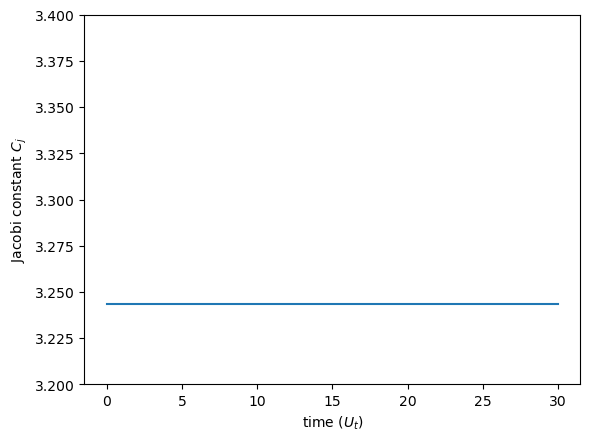

In [178]:
xrot = Yrot[:,0]
yrot = Yrot[:,1]
vxrot = Yrot[:,3]
vyrot = Yrot[:,4]

r1 = np.sqrt((xrot+mu2)**2+yrot**2)
r2 = np.sqrt((xrot-mu1)**2+yrot**2)

Cj = xrot**2+yrot**2+2*(mu1/r1+mu2/r2) -vxrot**2-vyrot**2

plt.plot(np.linspace(0,t,dt),Cj)
plt.xlabel(r'time ($U_t$)')
plt.ylabel(r'Jacobi constant $C_j$')
plt.ylim(3.2,3.4)

In [ ]:
r1 = np.sqrt((X+mu2)**2+Y**2)
r2 = np.sqrt((X-mu1)**2+Y**2)

In [ ]:
Z = X**2+Y**2+2*(mu1/r1+mu2/r2)-Cj
Z = X**2+Y**2+2*(mu1/r1+mu2/r2)-Cj

In [149]:
Cj = 3.245
mu = 0.02
mu1 = 1-mu
mu2 = mu

r1 = np.sqrt((X+mu2)**2+Y**2)
r2 = np.sqrt((X-mu1)**2+Y**2)

Z = X**2+Y**2+2*(mu1/r1+mu2/r2)-Cj

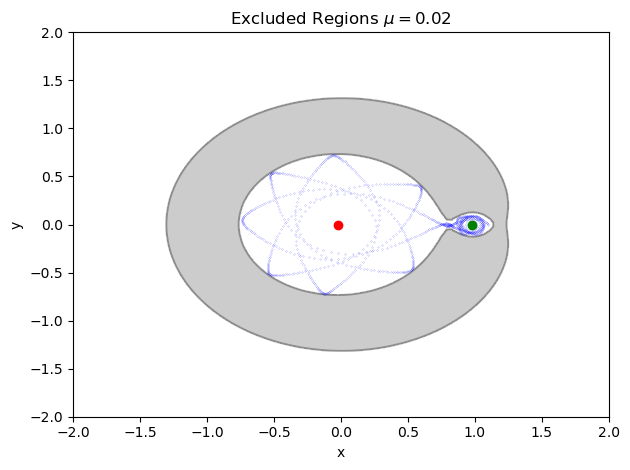

In [150]:
fig, ax = plt.subplots()
ax.contour(X,Y,Z,levels=[0],colors='k',alpha = 0.3)
ax.contourf(X,Y,Z,levels=[-100,0],colors='k',alpha = 0.2)
ax.plot(Yrot[:,0],Yrot[:,1],'bo',markersize = 0.1)
ax.plot(-mu2,0,'ro')
ax.plot(mu1,0,'go')
ax.plot()
ax.set_ylim(-2,2)
ax.set_xlim(-2,2)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_title('Excluded Regions $\mu = {}$'.format(mu))
plt.tight_layout()

This animated

In [166]:
fig = plt.figure(figsize=(9, 4.5))
ax=fig.gca()
camera_restriction = Camera(fig)
plt.ioff()
trace = []
for ti in range(dt):
    trace.append([Yrot[ti,0],Yrot[ti,1]])
    ax.contour(X,Y,Z,levels=[0],colors='k',alpha = 0.3)
    ax.contourf(X,Y,Z,levels=[-100,0],colors='k',alpha = 0.2)
    ax.plot(np.array(trace)[:,0],np.array(trace)[:,1],'bo',markersize = 0.1)
    ax.plot(Yrot[ti,0],Yrot[ti,1],'bo')
    ax.plot(mu,0,'ro')
    ax.plot(1-mu,0,'go')
    ax.axis('equal')
    camera_restriction.snap()
plt.tight_layout()
plt.close()
plt.ion()


In [167]:
restriction_animated = camera_restriction.animate(interval = 20)

In [168]:
HTML(restriction_animated.to_html5_video())

In [170]:
restriction_animated.save('restricction_Regions.mp4')